# Motion Clone

In [1]:
import pandas as pd
import numpy as np
import ortools
import matplotlib.pyplot as plt


In [156]:
HORIZON_WEEKS = 1
START_DATE = '2024-10-01'
WORKING_DAYS = "M-F"
WORKING_HOURS = (9, 17)  # Representing 9 AM to 5 PM as a range of hour


### Create A 15 minute Schedule

In [157]:
# Calculate the end date based on the horizon in weeks
end_date = pd.to_datetime(START_DATE) + pd.Timedelta(weeks=HORIZON_WEEKS)

# Create a new date range using the given parameters
date_range = pd.date_range(start=START_DATE, end=end_date, freq='15min')

# Create a DataFrame with the updated date range as the index
df_schedule = pd.DataFrame(index=date_range)
df_schedule 

""
2024-10-01 00:00:00
2024-10-01 00:15:00
2024-10-01 00:30:00
2024-10-01 00:45:00
2024-10-01 01:00:00
...
2024-10-07 23:00:00
2024-10-07 23:15:00
2024-10-07 23:30:00
2024-10-07 23:45:00


### Add data on working hours (1) and non-working hours (0)

In [158]:
# Add a column for the day of the week (dow)
df_schedule['dow'] = df_schedule.index.dayofweek  # Monday=0, Sunday=6

# Determine if the timestamp is within working hours and on a working day
df_schedule['working_hour'] = df_schedule.index.to_series().apply(
    lambda x: 1 if (x.weekday() < 5 and WORKING_HOURS[0] <= x.hour < WORKING_HOURS[1]) else 0
)
df_schedule

,dow,working_hour
2024-10-01 00:00:00,1,0
2024-10-01 00:15:00,1,0
2024-10-01 00:30:00,1,0
2024-10-01 00:45:00,1,0
2024-10-01 01:00:00,1,0
...,...,...
2024-10-07 23:00:00,0,0
2024-10-07 23:15:00,0,0
2024-10-07 23:30:00,0,0
2024-10-07 23:45:00,0,0


<Axes: title={'center': 'Working Hours'}>

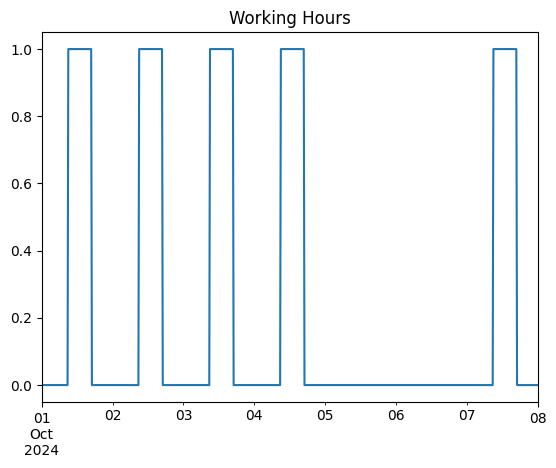

In [159]:
df_schedule['working_hour'].plot(title="Working Hours")

### Set up our task and existing events list

In [160]:
from pandas import Timestamp

tasks = {
     'Draft Proposal Document': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-04 13:00:00')},
     'Client Follow-up Email': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-07 10:00:00')},
     'Analyze Data Quality': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-08 22:30:00')},
     'Update Marketing Slide Deck': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-11 22:45:00')},
     'Create Team Strategy Outline': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-13 20:45:00')},
     'Reconcile Expense Sheets': {'time_to_complete': 15, 'due_date': Timestamp('2024-10-14 04:30:00')},
     'Prepare Design Mockups': {'time_to_complete': 15, 'due_date': Timestamp('2024-10-13 11:15:00')},
     'Debug System Errors': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-03 13:30:00')},
     'Compile Monthly Sales Report': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-07 20:15:00')},
     'Review Sales Forecast Spreadsheet': {'time_to_complete': 60, 'due_date': Timestamp('2024-10-14 20:30:00')},
     'Organize Training Materials': {'time_to_complete': 60, 'due_date': Timestamp('2024-10-06 05:30:00')},
     'Revise Website Content Draft': {'time_to_complete': 15, 'due_date': Timestamp('2024-10-06 07:30:00')},
     'Clean Up Codebase': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-01 10:00:00')},
     'Compile Financial Data for Q3': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-09 11:30:00')},
     'Audit SEO Performance Logs': {'time_to_complete': 15, 'due_date': Timestamp('2024-10-10 02:00:00')},
     'Organize Product Backlog': {'time_to_complete': 75, 'due_date': Timestamp('2024-10-02 01:15:00')},
     'Prepare Onboarding Checklist': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-08 23:30:00')},
     'Update Social Media Calendar': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-08 14:30:00')},
     'Create Client Onboarding Packet': {'time_to_complete': 60, 'due_date': Timestamp('2024-10-14 16:15:00')},
     'Run IT System Checks': {'time_to_complete': 60, 'due_date': Timestamp('2024-10-04 04:30:00')}
}

events = {
    'Project Kickoff Meeting': {'date_time': Timestamp('2024-10-01 06:45:00'), 'length': 60},
    'Client Status Update': {'date_time': Timestamp('2024-10-01 19:00:00'), 'length': 90},
    'Team Standup': {'date_time': Timestamp('2024-10-01 01:30:00'), 'length': 120},
    'Marketing Brainstorm Session': {'date_time': Timestamp('2024-10-01 18:45:00'), 'length': 120},
    'Design Review Roundtable': {'date_time': Timestamp('2024-10-02 09:30:00'), 'length': 30},
    'Budget Planning Discussion': {'date_time': Timestamp('2024-10-02 18:45:00'), 'length': 75},
    'IT Security Briefing': {'date_time': Timestamp('2024-10-02 18:15:00'), 'length': 120},
    'All Hands Staff Meeting': {'date_time': Timestamp('2024-10-02 17:15:00'), 'length': 30},
    'Product Development Sync': {'date_time': Timestamp('2024-10-03 05:15:00'), 'length': 30},
    'Content Strategy Session': {'date_time': Timestamp('2024-10-03 08:30:00'), 'length': 60},
    'Quarterly Business Review': {'date_time': Timestamp('2024-10-03 15:15:00'), 'length': 15},
    'User Experience Workshop': {'date_time': Timestamp('2024-10-04 18:00:00'), 'length': 30},
    'Sales Pipeline Review': {'date_time': Timestamp('2024-10-04 18:45:00'), 'length': 120},
    'Customer Feedback Session': {'date_time': Timestamp('2024-10-05 05:30:00'), 'length': 45},
    'Weekly Ops Check-In': {'date_time': Timestamp('2024-10-05 05:45:00'), 'length': 15},
    'Finance Forecast Update': {'date_time': Timestamp('2024-10-06 17:30:00'), 'length': 45},
    'Tech Team Code Review': {'date_time': Timestamp('2024-10-06 18:00:00'), 'length': 105},
    'Leadership Strategy Call': {'date_time': Timestamp('2024-10-06 15:45:00'), 'length': 120},
    'New Hire Orientation': {'date_time': Timestamp('2024-10-06 08:30:00'), 'length': 105},
    'HR Policy Review': {'date_time': Timestamp('2024-10-07 17:15:00'), 'length': 30},
    'Product Launch Strategy': {'date_time': Timestamp('2024-10-08 09:00:00'), 'length': 60},
    'Client Check-In': {'date_time': Timestamp('2024-10-08 14:30:00'), 'length': 90},
    'Departmental Budget Review': {'date_time': Timestamp('2024-10-09 10:15:00'), 'length': 120},
    'Operations Planning Meeting': {'date_time': Timestamp('2024-10-09 16:00:00'), 'length': 75},
    'Training and Development Session': {'date_time': Timestamp('2024-10-10 11:45:00'), 'length': 90},
    'Board of Directors Update': {'date_time': Timestamp('2024-10-10 14:00:00'), 'length': 120},
    'Annual Performance Review': {'date_time': Timestamp('2024-10-11 13:00:00'), 'length': 60},
    'IT Systems Upgrade Planning': {'date_time': Timestamp('2024-10-11 16:30:00'), 'length': 45},
    'Customer Engagement Workshop': {'date_time': Timestamp('2024-10-12 09:15:00'), 'length': 120},
    'End of Week Wrap-Up': {'date_time': Timestamp('2024-10-12 15:45:00'), 'length': 30},
    'Technical Documentation Review': {'date_time': Timestamp('2024-10-13 11:00:00'), 'length': 45},
    'Sales Strategy Workshop': {'date_time': Timestamp('2024-10-13 13:45:00'), 'length': 90},
    'Operations Overview Meeting': {'date_time': Timestamp('2024-10-14 08:30:00'), 'length': 120},
    'Year-End Planning Session': {'date_time': Timestamp('2024-10-14 14:15:00'), 'length': 105}
}




In [161]:
tasks = {
    'Complete Budget Draft': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-02 11:00:00')},
    'Client Meeting Preparation': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-03 09:00:00')},
    'Design Mockup Review': {'time_to_complete': 60, 'due_date': Timestamp('2024-10-04 16:00:00')},
    'Prepare Technical Report': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-03 15:30:00')},
    'Plan Marketing Strategy': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-04 14:00:00')},
    'Review Project Milestones': {'time_to_complete': 15, 'due_date': Timestamp('2024-10-02 14:30:00')},
    'Finalize Design Concepts': {'time_to_complete': 15, 'due_date': Timestamp('2024-10-04 12:15:00')},
    'Update Sales Materials': {'time_to_complete': 30, 'due_date': Timestamp('2024-10-01 17:30:00')},
    'Draft Training Manual': {'time_to_complete': 45, 'due_date': Timestamp('2024-10-03 12:00:00')},
    'Consolidate Performance Review': {'time_to_complete': 60, 'due_date': Timestamp('2024-10-04 19:00:00')}
}

events = {
    'Team Alignment Meeting': {'date_time': Timestamp('2024-10-01 09:00:00'), 'length': 60},
    'Sales Review Session': {'date_time': Timestamp('2024-10-01 15:00:00'), 'length': 90},
    'Product Roadmap Discussion': {'date_time': Timestamp('2024-10-02 10:00:00'), 'length': 120},
    'Technical Team Standup': {'date_time': Timestamp('2024-10-02 08:30:00'), 'length': 30},
    'Client Feedback Call': {'date_time': Timestamp('2024-10-03 11:00:00'), 'length': 45},
    'Marketing Strategy Brainstorm': {'date_time': Timestamp('2024-10-03 14:00:00'), 'length': 60},
    'Engineering Sync-Up': {'date_time': Timestamp('2024-10-04 09:00:00'), 'length': 90},
    'Finance Team Huddle': {'date_time': Timestamp('2024-10-04 11:30:00'), 'length': 30},
    'Operations Review': {'date_time': Timestamp('2024-10-04 14:30:00'), 'length': 60},
    'Customer Strategy Roundtable': {'date_time': Timestamp('2024-10-04 18:00:00'), 'length': 90}
}

### Lets block out our existing events on the schedule

In [162]:
# Assuming df_schedule is your existing DataFrame with datetime index
df_schedule['scheduled'] = 0  # Initialize 'scheduled' column as 0

# Loop through the meetings/events to update the 'scheduled' column
for event, details in events.items():
    start_time = details['date_time']
    duration_minutes = details['length']
    end_time = start_time + pd.Timedelta(minutes=duration_minutes)
    
    # Update the 'scheduled' column for the duration of the event
    df_schedule.loc[start_time:end_time, 'scheduled'] = 1

# Filter available slots for scheduling (within working hours and not scheduled)
df_schedule['available'] = (df_schedule['working_hour'] == 1) & (df_schedule['scheduled'] == 0)

# Create a time index for slots
df_schedule['time_index'] = range(len(df_schedule))
available_slots = df_schedule[df_schedule['available']].index

<Axes: title={'center': 'Already Scheduled Events'}>

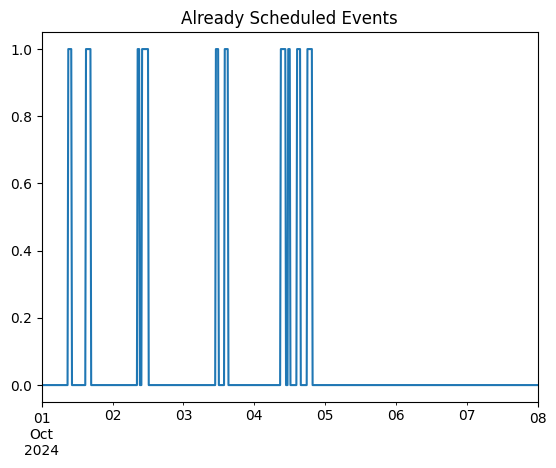

In [163]:
df_schedule['scheduled'].plot(title="Already Scheduled Events")

In [164]:
df_schedule

,dow,working_hour,scheduled,available,time_index
2024-10-01 00:00:00,1,0,0,False,0
2024-10-01 00:15:00,1,0,0,False,1
2024-10-01 00:30:00,1,0,0,False,2
2024-10-01 00:45:00,1,0,0,False,3
2024-10-01 01:00:00,1,0,0,False,4
...,...,...,...,...,...
2024-10-07 23:00:00,0,0,0,False,668
2024-10-07 23:15:00,0,0,0,False,669
2024-10-07 23:30:00,0,0,0,False,670
2024-10-07 23:45:00,0,0,0,False,671


### Lets write our optimization

In [170]:

model = cp_model.CpModel()

available = df_schedule['available'].tolist()

task_vars = {}

master_timestep_vars = [model.NewIntVar(name=f'scheduled_step_{i}', lb=0, ub=1) for i in range(0, df_schedule.shape[0])]

max_index = df_schedule['time_index'].max()

# Initialize `increment_vars` as a nested list where `increment_vars[task][offset]` is the occupancy of `task` at `offset`
increment_vars = [[model.NewBoolVar(f'increment_var_{task_name}_{offset}')
                   for offset in range(max_index + 1)] for task_name in tasks]


task_vars = []
task_start_vars = []
scheduled_vars = []
task_i = 0 

for task in tasks:
    details = tasks[task]
    due_time = details['due_date']
    duration = details['time_to_complete'] // 15
    task_increment_vars = increment_vars[task_i]
    # Find the maximum index allowed for the task to be completed before its due date
    max_due_index = df_schedule[df_schedule.index <= due_time]['time_index'].max()

    task_timesteps = [model.NewBoolVar(f'scheduled_step_{task}_{ts}') for ts in range(0, max_index)]

    start_timestep = model.NewIntVar(name=f'scheduled_start_step_{task}', ub=max_index, lb=0)

    scheduled_itterator = model.NewIntVar(name=f"scheduled_iter_{task}", lb=0, ub=duration + 1)
    scheduled = model.NewBoolVar(f"{task}_scheduled")
    # from start time, next n=duration timesteps must be true

    # Ensure that once a task starts, all the next `duration` time steps are occupied
    # Ensure that once a task starts, all the next `duration` time steps are occupied
    for offset in range(duration):
        # Create a shifted variable representing `start_timestep + offset`
        shifted_index = model.NewIntVar(0, max_due_index, f'shifted_index_{task}_{offset}')
        model.Add(shifted_index == start_timestep + offset)
        scheduled_var = model.NewBoolVar(f'Scheduled_{task}_{offset}')

        # Enforce that the corresponding timestep is `True`
        model.AddElement(shifted_index, task_timesteps, scheduled_var)
        model.AddElement(shifted_index, task_increment_vars, scheduled_var)

        model.Add(scheduled_var == 1)

    model.add(scheduled_itterator == sum(task_timesteps))

    # If `scheduled_iterator` >= `duration`, then `scheduled` is true
    model.add(scheduled_itterator >= duration).OnlyEnforceIf(scheduled)

    task_start_vars.append(start_timestep)
    scheduled_vars.append(scheduled)

    task_i += 1

for i in range(0, max_index):
    availability = available[i]
    indexed_increments = []
    for t in increment_vars:
        indexed_increments.append(t[i])

    model.Add(master_timestep_vars[i] == sum(indexed_increments))

    if availability == False:
        model.Add(master_timestep_vars[i] == 0)

total_scheduled = model.NewIntVar(name="Total_Scheduled", lb=0, ub=1000)

model.add(total_scheduled == sum(scheduled_vars))

model.Maximize(total_scheduled)

solver = cp_model.CpSolver()
status = solver.Solve(model)

# Output the results
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    print('Solution found:')
    t_i = 0
    for task_name in tasks.keys():
        is_scheduled = solver.Value(scheduled_vars[t_i])
        if is_scheduled:
            start_index = solver.Value(task_start_vars[t_i])
            start_time = df_schedule[df_schedule['time_index'] == start_index].index[0]
            print(f'{task_name} starts at {start_time}')

        else:
            print(f'{task_name} could not be scheduled')
        t_i = t_i + 1
else:
    print('No feasible solution found.')


Solution found:
Complete Budget Draft starts at 2024-10-01 14:30:00
Client Meeting Preparation starts at 2024-10-02 09:15:00
Design Mockup Review starts at 2024-10-01 10:15:00
Prepare Technical Report starts at 2024-10-02 16:15:00
Plan Marketing Strategy starts at 2024-10-02 12:15:00
Review Project Milestones starts at 2024-10-01 16:45:00
Finalize Design Concepts starts at 2024-10-04 10:45:00
Update Sales Materials starts at 2024-10-01 11:15:00
Draft Training Manual starts at 2024-10-01 13:45:00
Consolidate Performance Review starts at 2024-10-03 10:00:00


In [171]:
# Create a DataFrame to store the task schedule information
import matplotlib.dates as mdates

scheduled_tasks = []

t_i = 0
for task_name in tasks.keys():
    is_scheduled = solver.Value(scheduled_vars[t_i])
    if is_scheduled:
        start_index = solver.Value(task_start_vars[t_i])
        start_time = df_schedule[df_schedule['time_index'] == start_index].index[0]
        duration = tasks[task_name]['time_to_complete'] // 15  # Duration in 15-minute increments
        end_time = start_time + pd.Timedelta(minutes=duration * 15)

        scheduled_tasks.append({
            'task_name': task_name,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration * 15  # Convert back to minutes
        })
    t_i += 1

# Convert to DataFrame for easy plotting
scheduled_df = pd.DataFrame(scheduled_tasks)

# Print the schedule for reference
scheduled_df

,task_name,start_time,end_time,duration
0,Complete Budget Draft,2024-10-01 14:30:00,2024-10-01 15:00:00,30
1,Client Meeting Preparation,2024-10-02 09:15:00,2024-10-02 10:00:00,45
2,Design Mockup Review,2024-10-01 10:15:00,2024-10-01 11:15:00,60
3,Prepare Technical Report,2024-10-02 16:15:00,2024-10-02 17:00:00,45
4,Plan Marketing Strategy,2024-10-02 12:15:00,2024-10-02 12:45:00,30
5,Review Project Milestones,2024-10-01 16:45:00,2024-10-01 17:00:00,15
6,Finalize Design Concepts,2024-10-04 10:45:00,2024-10-04 11:00:00,15
7,Update Sales Materials,2024-10-01 11:15:00,2024-10-01 11:45:00,30
8,Draft Training Manual,2024-10-01 13:45:00,2024-10-01 14:30:00,45
9,Consolidate Performance Review,2024-10-03 10:00:00,2024-10-03 11:00:00,60


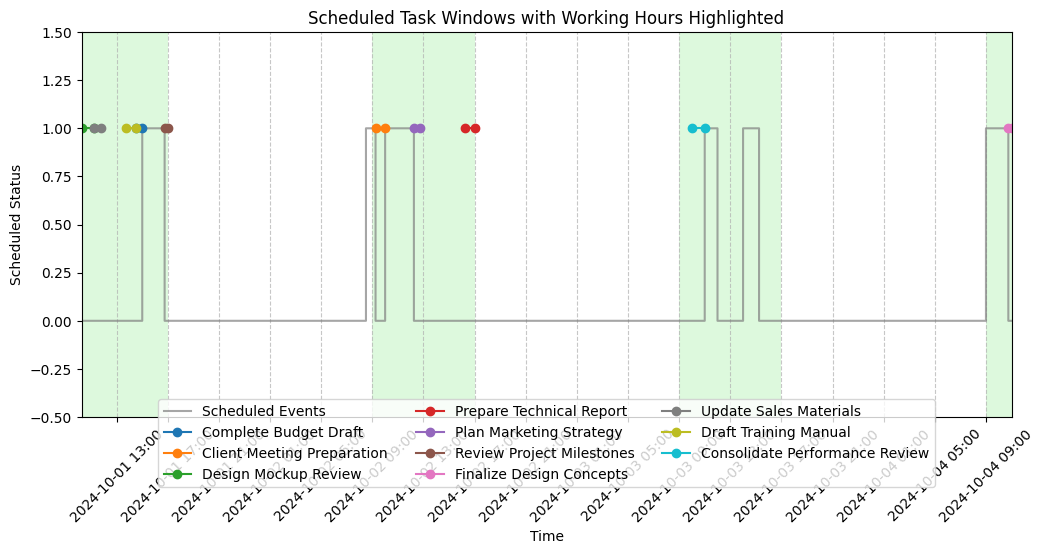

In [172]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 5))  # Fixed height for easier distinction

# Plot the existing scheduled events as a line
ax.step(df_schedule.index, df_schedule['scheduled'], label='Scheduled Events', where='post', color='gray', alpha=0.7)

# Plot the working hours as a background color (1 for working hours, 0 for non-working hours)
for start_time, working in zip(df_schedule.index, df_schedule['working_hour']):
    # Shade the background if it's working hours
    if working == 1:
        ax.axvspan(start_time, start_time + pd.Timedelta(minutes=15), facecolor='lightgreen', alpha=0.3)

# Plot the tasks' start and end times as dots, connected by a line at y = 1
for index, row in scheduled_df.iterrows():
    ax.plot([row['start_time'], row['end_time']], [1, 1], marker='o', label=row['task_name'])

# Format the x-axis as datetime
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))  # Set interval for major ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Label the plot
ax.set_xlabel('Time')
ax.set_ylabel('Scheduled Status')
ax.set_title('Scheduled Task Windows with Working Hours Highlighted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set the y-axis limits to distinguish between `scheduled` status and task markers
plt.ylim(-0.5, 1.5)

# Set the x-axis limits based on the earliest start and latest end time to zoom in on active tasks
plt.xlim(scheduled_df['start_time'].min(), scheduled_df['end_time'].max())

# Display grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)


# Display the plot
# plt.tight_layout()
plt.show()
